# This note book will illustrate the Iris regridding algorithms used. For a small sampling combined land-sea area, the temperature phenomena are regridded from APS3 grids to APS2 grids for testing.

## The idea to be tested:
## a) Does Scipy Interpolation differ by applying coastline correction?
## b) How about Iris Regrid algorithm?

In [1]:
import iris
import sys

### This is loading metadata from a sample testing area retrieving from APS3 UM files.

In [2]:
from machine_learning_regrid.tools.iris_tools import *

In [3]:
topo_aps2 = empty_3d_cube_aps2(
    surface_alt_aps2_data, 'surface_altitude', 'm', 'm01s00i033')
topo_aps3 = empty_3d_cube_aps3(
    surface_alt_aps3_data, 'surface_altitude', 'm', 'm01s00i033')
lsm_aps2 = empty_3d_cube_aps2(
    lsm_aps2_data, 'land_area_fraction', '1', )
lsm_aps3 = empty_3d_cube_aps3(
    lsm_aps3_data, 'land_area_fraction', '1')
t_scn_aps3 = empty_3d_cube_aps3(
    t_scn_aps3_data, 'air_temperature', 'K')
dpt_scn_aps3 = empty_3d_cube_aps3(
    dpt_scn_aps3_data, 'dew_point_temperature', 'K', 'm01s03i250')
sfc_prs_aps3 = empty_3d_cube_aps3(
    sfc_prs_aps3_data, 'air_pressure_at_sea_level', 'Pa')

In [4]:
print(lsm_aps3.data)

[[1 1 0 0 0 0]
 [1 1 1 0 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]]


In [5]:
print(lsm_aps2.data)

[[ 1.  0.  0.]
 [ 1.  1.  0.]
 [ 1.  1.  0.]]


In [6]:
print(topo_aps3.data)

[[  30.79901695   24.64077759    0.            0.            0.            0.        ]
 [  40.51713181   57.62937927   44.1620636     0.            0.            0.        ]
 [  61.04179001   77.5438385    68.0868454    27.50967216    0.            0.        ]
 [ 197.31484985  109.88461304   81.08721161   47.29803085    0.            0.        ]
 [ 500.52633667  204.61886597   96.57264709   57.00541687    0.            0.        ]
 [ 801.8571167   337.81097412  131.99372864   66.28527832    0.            0.        ]]


### What the regrid points look like, ie. APS3 to APS2?

In [7]:
print(lsm_aps2.coord('latitude').points)
print(lsm_aps2.coord('longitude').points)

[ 6.328125  6.5625    6.796875]
[ 81.211053  81.562616  81.914179]


In [8]:
print(lsm_aps3.coord('latitude').points)
print(lsm_aps3.coord('longitude').points)

[ 6.26953125  6.38671875  6.50390625  6.62109375  6.73828125  6.85546875]
[ 81.12304688  81.29882812  81.47460938  81.65039062  81.82617188
  82.00195312]


In [9]:
import numpy as np
def product(*iterables):
    """ Equivalent of itertools.product for versions < 2.6,
        which does NOT build intermediate results.
        Omitted 'repeat' option.
        product('ABCD', 'xy') --> Ax Ay Bx By Cx Cy Dx Dy
    """
    nIters = len(iterables)
    lstLenths = []
    lstRemaining = [1]
    for i in xrange(nIters-1,-1,-1):
        m = len(iterables[i])
        lstLenths.insert(0, m)
        lstRemaining.insert(0, m * lstRemaining[0])
    nProducts = lstRemaining.pop(0)

    for p in xrange(nProducts):
        lstVals = []

        for i in xrange(nIters):
            j = p/lstRemaining[i]%lstLenths[i]
            lstVals.append(iterables[i][j])
        yield tuple(lstVals)
        
def calc_cube_point_product(cube):
    x = cube.coord('longitude').points[:]
    y = cube.coord('latitude').points[:]
    cube_points = np.array(list(product(x,y)))
    return cube_points

In [10]:
aps2_points = calc_cube_point_product(topo_aps2)
aps3_points = calc_cube_point_product(topo_aps3)

In [11]:
topo_aps2.coord('longitude').points[:]

array([ 81.211053,  81.562616,  81.914179])

In [12]:
print(aps2_points)

[[ 81.211053   6.328125]
 [ 81.211053   6.5625  ]
 [ 81.211053   6.796875]
 [ 81.562616   6.328125]
 [ 81.562616   6.5625  ]
 [ 81.562616   6.796875]
 [ 81.914179   6.328125]
 [ 81.914179   6.5625  ]
 [ 81.914179   6.796875]]


In [13]:
x_interval = topo_aps2.coord('longitude').points[1] - topo_aps2.coord('longitude').points[0]
y_interval = topo_aps2.coord('latitude').points[1] - topo_aps2.coord('latitude').points[0]
print(x_interval, y_interval)

(0.35156299999999874, 0.234375)


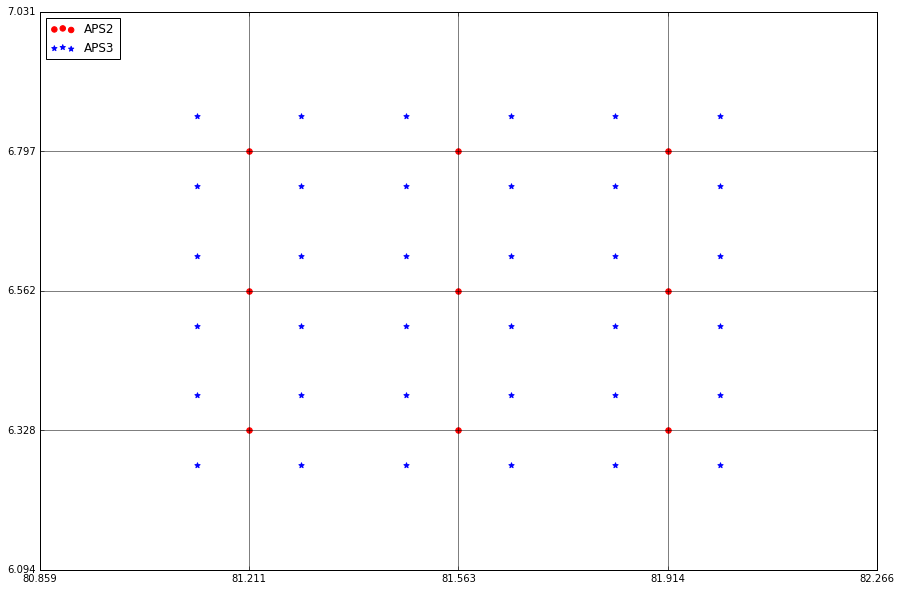

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

fig, ax=plt.subplots()
#fig = plt.figure()

loc_x = plticker.MultipleLocator(base=x_interval)
loc_y = plticker.MultipleLocator(base=y_interval)

ax.xaxis.set_major_locator(loc_x)
ax.yaxis.set_major_locator(loc_y)

# Add the grid
ax.grid(which='major', axis='both', linestyle='-')

aps2 = plt.scatter(*zip(*aps2_points), marker='o', s=30, color='red')
aps3 = plt.scatter(*zip(*aps3_points), marker='*', s=30, color='blue')

#plt.grid()
plt.legend((aps2, aps3), ('APS2', 'APS3'), loc=2)
fig.set_size_inches(15, 10)
plt.show()

# 1. Now Regrid Linear with Coastline Correction using the available algorithms, i.e. Iris & Scipy

In [15]:
from iris.cube import CubeList

In [16]:
# inputs
input_cubes = CubeList([])
input_cubes.append(t_scn_aps3)
input_cubes.append(dpt_scn_aps3)
# in_grids
in_grids = CubeList([])
in_grids.append(topo_aps3)
in_grids.append(lsm_aps3)
# out_grids
out_grids = CubeList([])
out_grids.append(topo_aps2)
out_grids.append(lsm_aps2)

In [17]:
from machine_learning_regrid.ml_regrid import (
    regrid_cube_by_iris_scheme)

In [18]:
def plot_two_cubes_in_same_scale(origin_cube, derived_cube, label_origin='Origin_UM', label_derived='Regridded_Data'):
    import matplotlib.pyplot as plt
    import iris.quickplot as qplt
    
    fig = plt.figure(figsize=(18, 12))

    fig.add_subplot(221)
    cm = qplt.pcolormesh(origin_cube)    
    plt.gca().coastlines()

    fig.add_subplot(222)
    qplt.pcolormesh(derived_cube, cmap=cm.cmap, norm=cm.norm)
    plt.gca().coastlines()

    print("             {}                                           {}".format(label_origin, label_derived))

    plt.show()

/data/hwang/conda/miniconda3/envs/pre-proc-py2/lib/python2.7/site-packages/iris/coords.py:821: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/data/hwang/conda/miniconda3/envs/pre-proc-py2/lib/python2.7/site-packages/iris/coords.py:821: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


             LSM_APS3                                           LSM_APS2


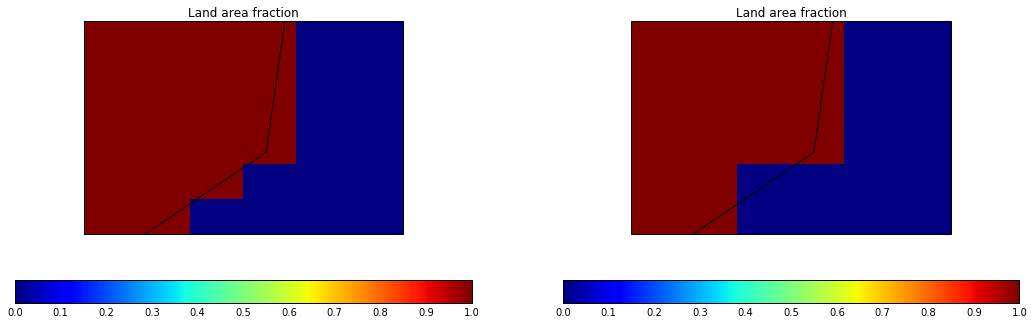

In [51]:
plot_two_cubes_in_same_scale(lsm_aps3, lsm_aps2, label_origin='LSM_APS3', label_derived='LSM_APS2')

## 1.1 Air-temperature 

### 1.1.1 Iris Regridding

In [19]:
drv_t_scn_iris = regrid_cube_by_iris_scheme(t_scn_aps3, topo_aps2, scheme='linear')

Processing air_temperature
Processing dew_point_temperature


             Origin_UM                                           Regridded_Data


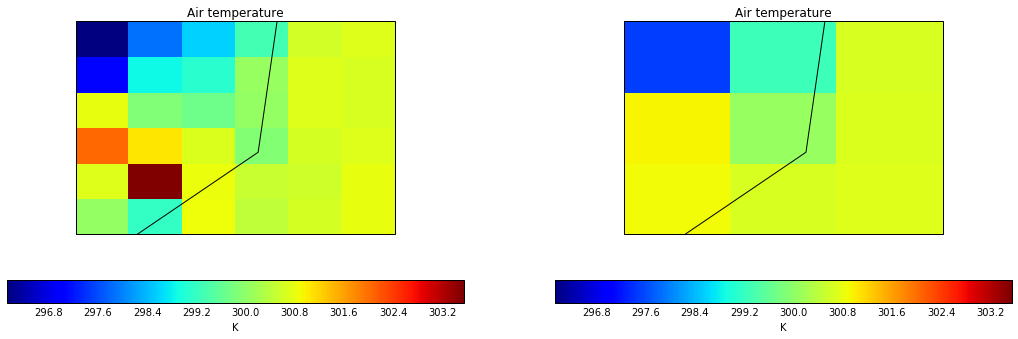

In [21]:
plot_two_cubes_in_same_scale(t_scn_aps3, drv_t_scn_iris)

In [22]:
print(drv_t_scn_iris.data)

[[ 300.88344903  300.66382534  300.70716069]
 [ 300.95641012  300.08969424  300.68359893]
 [ 297.48944652  299.26620242  300.67580714]]


### Conclusion Remarks 1.1.1: Iris regridding algorithm 'regrid_linear_iris_coastline' is also doing a reasonable job.

### 1.1.2 Scipy all interpolation (no coastline correction)

In [23]:
def get_grid_vector(lat, lon):
    """
    Convert input lat, lon (nparray) into grid_mesh for scipy interpolate;
    First step to prepare for scipy interpolation.
    """
    import numpy as np
    lat_mesh, lon_mesh = np.meshgrid(lat, lon)
    lat_vec = np.ravel(lat_mesh)
    lon_vec = np.ravel(lon_mesh)
    return lat_vec, lon_vec

def get_grid_points(lat, lon):
    """
    Convert input lat, lon (nparray) into grid_points for scipy interpolate.
    """
    lat_vec, lon_vec = get_grid_vector(lat, lon)
    grid_points = np.vstack((lat_vec, lon_vec)).T
    return grid_points

def interpolate_by_scipy(src_data, lat_src, lon_src, lat_tgt, lon_tgt, method='linear'):
    """
    Use Scipy to interpolate input source data to target grid.
    ------
    Input:
        src_data: the metadata on src_grids
        lat_src or lat_tgt: the latitude 1d np.array from source or target grids
        lon_src or lon_tgt: the longitude 1d np.array from source or target grids
        method: the interpolate method used by scipy RegularGridInterpolator
                only available "linear" & "nearest"
    Output:
        tgt_data: the interpolated data on target grids.
    """
    import scipy.interpolate as interpolator

    # Need prepare grid_points and vestor for scipy interpolator
    src_data_vec = np.ravel(src_data)
    grid_points_src = get_grid_points(lat_src, lon_src)
    lat_tgt_vec, lon_tgt_vec = get_grid_vector(lat_tgt, lon_tgt)
    
    # Define the interpolator
    if method == 'linear':
        scipy_interp = interpolator.LinearNDInterpolator(grid_points_src, src_data_vec)
    elif method == 'nearest':
        scipy_interp = interpolator.NearestNDInterpolator(grid_points_src, src_data_vec)
    else:
        raise ValueError("Only linear and nearest interpolations are available!")
    # Derive
    tgt_data = scipy_interp(lat_tgt_vec, lon_tgt_vec)
    # Need reshape back to 2d
    tgt_data = tgt_data.reshape(len(lat_tgt), len(lon_tgt))
    return tgt_data

In [25]:
from machine_learning_regrid.tools.iris_tools import *

In [26]:
def interpolate_cube_by_scipy(src_cube, src_grid_cube, tgt_grid_cube, method='linear'):
    """
    Use Scipy to interpolate input cube (source data) to target grid.
    ------
    Input:
        src_cube: the metadata cube on src_grids
        src_grid_cube: a cube with source grids
        tgt_grid_cube: a cube with target grids
        method: the interpolate method used by scipy RegularGridInterpolator
                only available "linear" & "nearest"
    Output:
        tgt_data: the interpolated data on target grids.
    """
    import scipy.interpolate as interpolator

    # Need prepare grid_points and vestor for scipy interpolator
    src_data = src_cube.data
    src_data_vec = np.ravel(src_data)
    
    # lat_src or lat_tgt: the latitude 1d np.array from source or target grids
    # lon_src or lon_tgt: the longitude 1d np.array from source or target grids
    lat_src = src_grid_cube.coord('latitude').points
    lon_src = src_grid_cube.coord('longitude').points
    
    lat_tgt = tgt_grid_cube.coord('latitude').points
    lon_tgt = tgt_grid_cube.coord('longitude').points
    
    grid_points_src = get_grid_points(lat_src, lon_src)
    lat_tgt_vec, lon_tgt_vec = get_grid_vector(lat_tgt, lon_tgt)
    
    # Define the interpolator
    if method == 'linear':
        scipy_interp = interpolator.LinearNDInterpolator(grid_points_src, src_data_vec)
    elif method == 'nearest':
        scipy_interp = interpolator.NearestNDInterpolator(grid_points_src, src_data_vec)
    else:
        raise ValueError("Only linear and nearest interpolations are available!")
    # Derive
    tgt_data = scipy_interp(lat_tgt_vec, lon_tgt_vec)
    # Need reshape back to 2d
    tgt_data = tgt_data.reshape(len(lat_tgt), len(lon_tgt))
    
    tgt_cube = create_derive_cube(src_cube, tgt_grid_cube)
    tgt_cube.data = tgt_data
    return tgt_cube

In [27]:
drv_t_scn_scipy_one = interpolate_cube_by_scipy(t_scn_aps3, topo_aps3, topo_aps2)

             Origin_UM                                           Regridded_Data


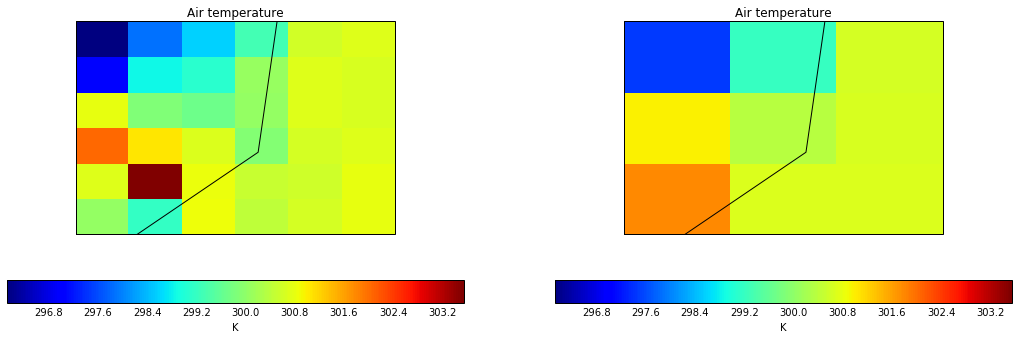

In [28]:
plot_two_cubes_in_same_scale(t_scn_aps3, drv_t_scn_scipy_one)

In [29]:
drv_t_scn_scipy_one.data

array([[ 301.80512897,  300.69529197,  300.69530223],
       [ 300.9757273 ,  300.37434009,  300.64848906],
       [ 297.47593081,  299.21058541,  300.62505178]])

In [30]:
drv_t_scn_iris.data

array([[ 300.88344903,  300.66382534,  300.70716069],
       [ 300.95641012,  300.08969424,  300.68359893],
       [ 297.48944652,  299.26620242,  300.67580714]])

### 1.1.3 Scipy two stage interpolate (use coastline correction)

In [31]:
def get_land_sea_index(lsm_cube):
    """
    Return the land_indx and sea_indx from a given lsm_cube.
    """
    sea_index = (lsm_cube.data == 0)
    land_index = (lsm_cube.data != 0)
    return land_index, sea_index

def transform_cube_by_masked_index(cube, masked_indx):
    """
    Transform the input cube based the land or sea mark given
    """
    new_cube_data = np.ma.masked_array(cube.data, mask=masked_indx)
    new_cube = cube.copy()
    new_cube.data = new_cube_data
    return new_cube

In [32]:
def two_stage_interp_cube(cube_src, topo_tgt, lsm_src, lsm_tgt, method='linear'):
    """
    Do two stages interpolation (land & sea) seperately and then
    integrate the results together by using Scipy Interpolate.
    ------
    Input:
        cube_src: the phenomenon cube with the source grid;
        topo_tgt: the topography cube with the target grid;
        lsm_src: land sea mask for the source grid;
        lsm_tgt: land sea mask for the target grid;
        method: the interpolate method used by scipy RegularGridInterpolator
                only available "linear" & "nearest"
    Output:
        drv_cube: the regridded cube on the target grid
                  with integrated data of both land and sea.
    """
    # Get the land and sea index for both grids
    land_indx_src, sea_indx_src = get_land_sea_index(lsm_src)
    land_indx_tgt, sea_indx_tgt = get_land_sea_index(lsm_tgt)

    # Mask the src sea points for land cube
    cube_land_src = transform_cube_by_masked_index(cube_src, sea_indx_src)
    # Mask the src land points
    cube_sea_src = transform_cube_by_masked_index(cube_src, land_indx_src)
    # Mask the tgt sea points
    topo_land_tgt = transform_cube_by_masked_index(topo_tgt, sea_indx_tgt)
    # Mask the tgt land points
    topo_sea_tgt = transform_cube_by_masked_index(topo_tgt, land_indx_tgt)

    # Get the grids for both source and target
    land_grids_src = get_cube_grid_points(cube_land_src)
    sea_grids_src = get_cube_grid_points(cube_sea_src)

    land_grids_tgt = get_cube_grid_points(topo_land_tgt)
    sea_grids_tgt = get_cube_grid_points(topo_sea_tgt)

    # Derive the cube_aps2 from aps3
    drv_cube_land_data = interp_by_scipy(
        cube_land_src.data, land_grids_src, land_grids_tgt, method=method)

    drv_cube_sea_data = interp_by_scipy(
        cube_sea_src.data, sea_grids_src, sea_grids_tgt, method=method)    
    
    # Combine the land & sea data together
    drv_cube_tgt = create_derive_cube(cube_src, topo_tgt)
    # Update with land data
    combined_data = np.where(land_indx_tgt,
                             drv_cube_land_data, drv_cube_tgt.data)
    # Update with sea data
    combined_data = np.where(sea_indx_tgt,
                             drv_cube_sea_data, combined_data)
    # update the cube with integrated data
    drv_cube = update_cube_with_new_data(drv_cube_tgt, combined_data)
    return drv_cube

In [33]:
drv_t_scn_scipy_two_stage = two_stage_interp(
            t_scn_aps3, topo_aps2, lsm_aps3, lsm_aps2)

             Origin_UM                                           Regridded_Data


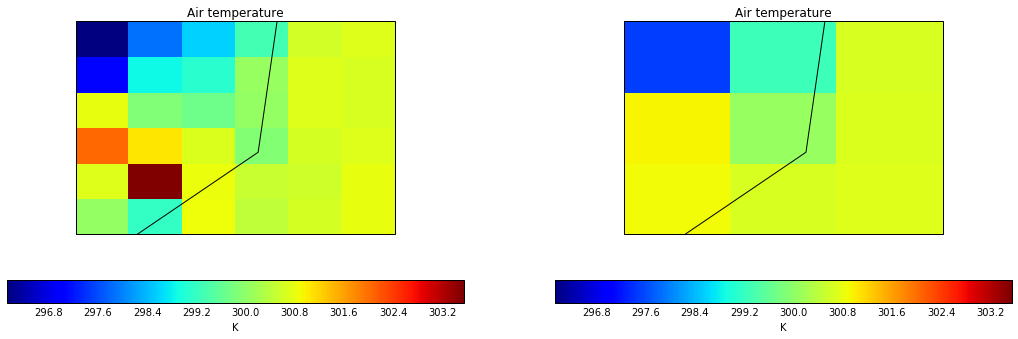

In [34]:
plot_two_cubes_in_same_scale(t_scn_aps3, drv_t_scn_scipy_two_stage)

In [35]:
drv_t_scn_scipy_one.data

array([[ 301.80512897,  300.69529197,  300.69530223],
       [ 300.9757273 ,  300.37434009,  300.64848906],
       [ 297.47593081,  299.21058541,  300.62505178]])

In [36]:
drv_t_scn_scipy_two_stage.data

array([[ 300.88446543,  300.66408303,  300.70700558],
       [ 300.95622183,  300.08956019,  300.68359891],
       [ 297.48763403,  299.26520042,  300.67576572]])

             Scipy_regridded_one_step                                           Scipy_two_step_regrid


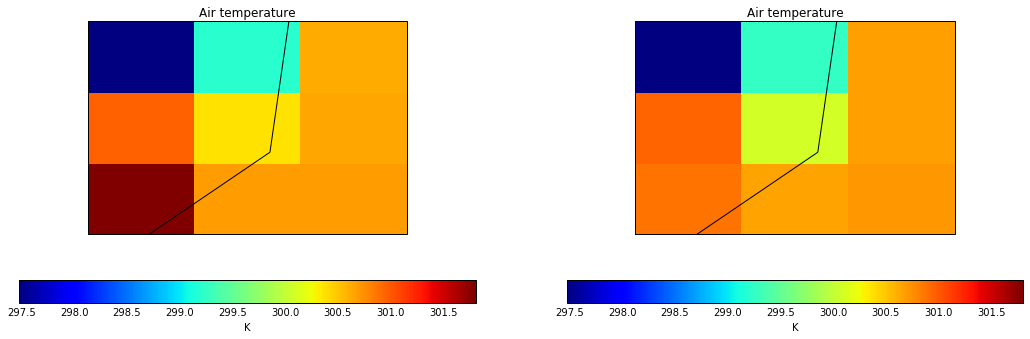

In [52]:
plot_two_cubes_in_same_scale(drv_t_scn_scipy_one, drv_t_scn_scipy_two_stage, "Scipy_regridded_one_step", "Scipy_two_step_regrid")

In [42]:
def show_difference(cube_a, cube_b, accuracy=None, entropy=None):
    import numpy as np
    from numpy.testing import assert_array_less
    
    result = cube_a.data.flatten()
    expected = cube_b.data.flatten()
    
    if accuracy is None:
        accuracy = np.repeat(0.0001, len(result))
    if entropy is None:
        entropy = 0.02
    # Now assert the data is as expected.
    delta = np.abs(result - expected)
    msg = ('\nEntropy: {}\nExpected entropy: {}\n'
           'Index  -/x   Delta     Target   Expected value   Actual Value'
           ''.format(delta.sum(), entropy))
    template = '\n{0:3}     {1:2}  {2:6f}  {3:6f}    {4:6f}      {5:6f}'

    for i, (r_del, t_del, r, t) in enumerate(zip(delta, accuracy,
                                                 result, expected)):
        msg += template.format(i, '-' if r_del < t_del else 'x',
                               r_del, t_del,
                               t, r)
    # Ensure each accuracy component falls below the target.
    assert_array_less(delta, accuracy, msg)
    # Ensure that our entropy is close to the expected one.
    # If this fails because the result is now smaller than expected, good!
    # It means we can tighten the expected entropy *AND* the target delta.
    if np.abs(entropy - delta.sum()) > 0.001:
        print(msg)

In [44]:
show_difference(drv_t_scn_scipy_one, drv_t_scn_scipy_two_stage)

AssertionError: 
Arrays are not less-ordered

Entropy: 1.42000319989
Expected entropy: 0.02
Index  -/x   Delta     Target   Expected value   Actual Value
  0     x   0.920664  0.000100    300.884465      301.805129
  1     x   0.031209  0.000100    300.664083      300.695292
  2     x   0.011703  0.000100    300.707006      300.695302
  3     x   0.019505  0.000100    300.956222      300.975727
  4     x   0.284780  0.000100    300.089560      300.374340
  5     x   0.035110  0.000100    300.683599      300.648489
  6     x   0.011703  0.000100    297.487634      297.475931
  7     x   0.054615  0.000100    299.265200      299.210585
  8     x   0.050714  0.000100    300.675766      300.625052
(mismatch 100.0%)
 x: array([ 0.920664,  0.031209,  0.011703,  0.019505,  0.28478 ,  0.03511 ,
        0.011703,  0.054615,  0.050714])
 y: array([ 0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,
        0.0001,  0.0001])

## 1.2 Air-temperature Regridding Result Comparison

             Iris_regridded_data                                           Scipy_one_step_regrid


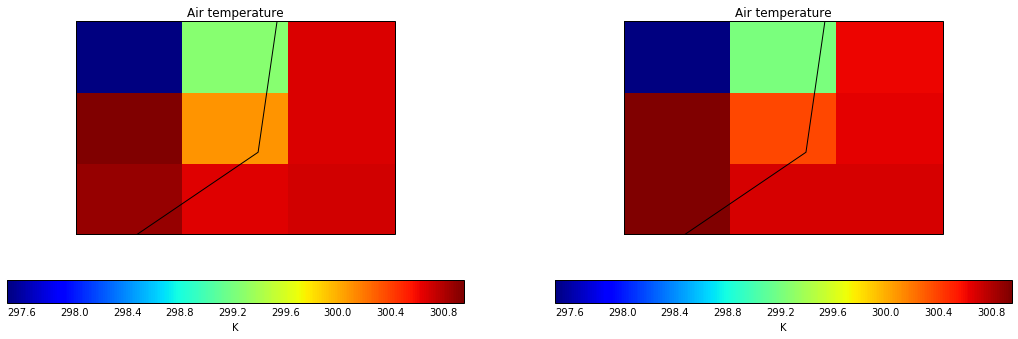

In [39]:
plot_two_cubes_in_same_scale(drv_t_scn_iris, drv_t_scn_scipy_one, "Iris_regridded_data", "Scipy_one_step_regrid")

             Iris_regridded_data                                           Scipy_two_step_regrid


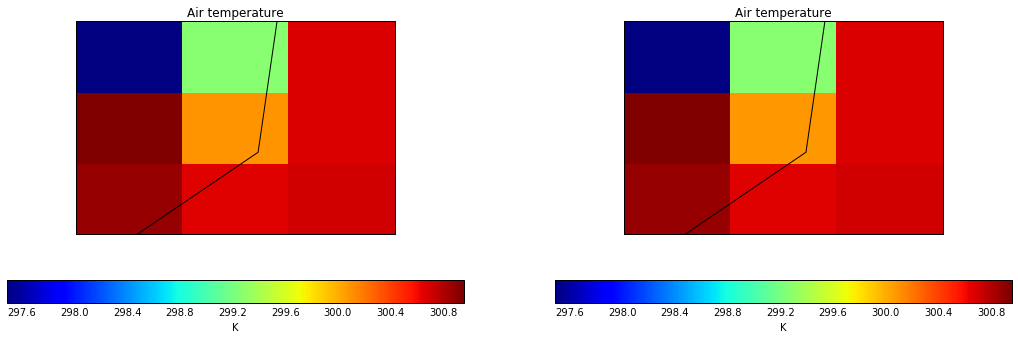

In [40]:
plot_two_cubes_in_same_scale(drv_t_scn_iris, drv_t_scn_scipy_two_stage, "Iris_regridded_data", "Scipy_two_step_regrid")

In [43]:
show_difference(drv_t_scn_iris, drv_t_scn_scipy_one)

AssertionError: 
Arrays are not less-ordered

Entropy: 1.42396600012
Expected entropy: 0.02
Index  -/x   Delta     Target   Expected value   Actual Value
  0     x   0.921680  0.000100    301.805129      300.883449
  1     x   0.031467  0.000100    300.695292      300.663825
  2     x   0.011858  0.000100    300.695302      300.707161
  3     x   0.019317  0.000100    300.975727      300.956410
  4     x   0.284646  0.000100    300.374340      300.089694
  5     x   0.035110  0.000100    300.648489      300.683599
  6     x   0.013516  0.000100    297.475931      297.489447
  7     x   0.055617  0.000100    299.210585      299.266202
  8     x   0.050755  0.000100    300.625052      300.675807
(mismatch 100.0%)
 x: array([ 0.92168 ,  0.031467,  0.011858,  0.019317,  0.284646,  0.03511 ,
        0.013516,  0.055617,  0.050755])
 y: array([ 0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,
        0.0001,  0.0001])

In [45]:
show_difference(drv_t_scn_iris, drv_t_scn_scipy_two_stage)

AssertionError: 
Arrays are not less-ordered

Entropy: 0.00460746692903
Expected entropy: 0.02
Index  -/x   Delta     Target   Expected value   Actual Value
  0     x   0.001016  0.000100    300.884465      300.883449
  1     x   0.000258  0.000100    300.664083      300.663825
  2     x   0.000155  0.000100    300.707006      300.707161
  3     x   0.000188  0.000100    300.956222      300.956410
  4     x   0.000134  0.000100    300.089560      300.089694
  5     -   0.000000  0.000100    300.683599      300.683599
  6     x   0.001812  0.000100    297.487634      297.489447
  7     x   0.001002  0.000100    299.265200      299.266202
  8     -   0.000041  0.000100    300.675766      300.675807
(mismatch 77.7777777778%)
 x: array([  1.016400e-03,   2.576889e-04,   1.551111e-04,   1.882889e-04,
         1.340445e-04,   2.222225e-08,   1.812489e-03,   1.002000e-03,
         4.142222e-05])
 y: array([ 0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,
        0.0001,  0.0001])

## Conclusion Remarks: Iris regrid results are more close to Scipy coastline correction interpolation results.

## 1.3 Iris regrid intergrates with coastline correction

In [47]:
def two_stage_interp(cube_aps3, cube_aps2, lsm_src, lsm_tgt, **args):
    """
    Do two stages interpolation (land & sea) seperately and then
    integrate the results together.
    ------
    Input:
        cube_aps3: the source cube with APS3 grid;
        cube_aps2: the target cube with APS2 grid;
        lsm_src: land/sea mask cube from source grids
        lsm_src: land/sea mask cube from target grids
        land_aps3(or aps2)_indx: land index for a grid;
        sea_aps3(or aps2)_indx: sea index for a grid;
    Output:
        drv_cube_land_aps2: an updated regridded cube with integrated data
                            of both land and sea although named by land.
    """
    # Get the land and sea index for both grids
    land_aps3_indx, sea_aps3_indx = get_land_sea_index(lsm_src)
    land_aps2_indx, sea_aps2_indx = get_land_sea_index(lsm_tgt)
    
    # Mask the APS3 sea points
    cube_land_aps3 = transform_cube_by_masked_index(cube_aps3, sea_aps3_indx)
    # Mask the APS3 land points
    cube_sea_aps3 = transform_cube_by_masked_index(cube_aps3, land_aps3_indx)
    # Mask the APS2 sea points
    cube_land_aps2 = transform_cube_by_masked_index(cube_aps2, sea_aps2_indx)
    # Mask the APS2 land points
    cube_sea_aps2 = transform_cube_by_masked_index(cube_aps2, land_aps2_indx)

    # Derive the cube_aps2 from aps3
    drv_cube_land_aps2 = cube_land_aps3.regrid(
                            cube_land_aps2, iris.analysis.Linear())
    drv_cube_sea_aps2 = cube_sea_aps3.regrid(
                            cube_sea_aps2, iris.analysis.Linear())

    # Combine the land & sea data together
    combined_data = drv_cube_land_aps2.data
    combined_data = np.where(sea_aps2_indx,
                             drv_cube_sea_aps2.data, combined_data)
    # update the cube with integrated data
    drv_cube_land_aps2.data = combined_data

    return drv_cube_land_aps2

In [48]:
drv_t_scn_iris_two_stage = two_stage_interp(t_scn_aps3, topo_aps2, lsm_aps3, lsm_aps2)

             Iris_regridded_data                                           Iris_two_step_regrid


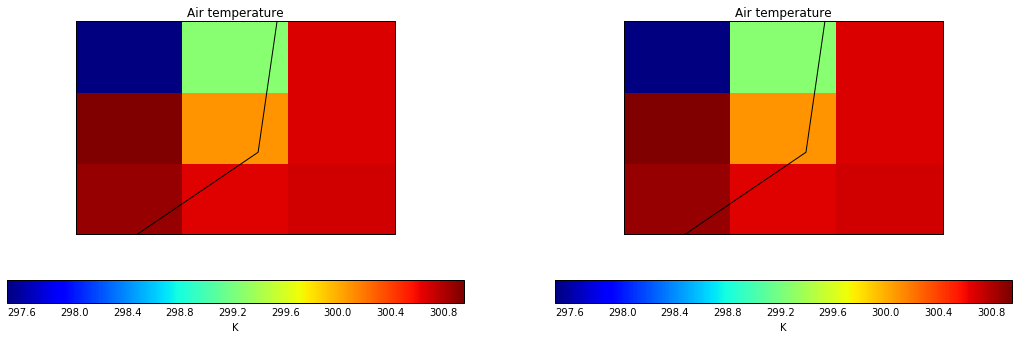

In [49]:
plot_two_cubes_in_same_scale(drv_t_scn_iris, drv_t_scn_iris_two_stage, "Iris_regridded_data", "Iris_two_step_regrid")

In [50]:
show_difference(drv_t_scn_iris, drv_t_scn_iris_two_stage)


Entropy: 0.0
Expected entropy: 0.02
Index  -/x   Delta     Target   Expected value   Actual Value
  0     -   0.000000  0.000100    300.883449      300.883449
  1     -   0.000000  0.000100    300.663825      300.663825
  2     -   0.000000  0.000100    300.707161      300.707161
  3     -   0.000000  0.000100    300.956410      300.956410
  4     -   0.000000  0.000100    300.089694      300.089694
  5     -   0.000000  0.000100    300.683599      300.683599
  6     -   0.000000  0.000100    297.489447      297.489447
  7     -   0.000000  0.000100    299.266202      299.266202
  8     -   0.000000  0.000100    300.675807      300.675807
